### 1. Import data analysis libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from scipy.stats import norm
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.preprocessing import StandardScaler
from scipy import stats
import data_cleaning

train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
train_ID = train['Id']
test_ID = test['Id']

# drop ID for now, b/c you don't want to mix it with other numerical features 
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

# df is the merged dataset (train + test)
#df = pd.concat((train, test)).reset_index(drop=True)

## 2. Overall EDA (Distribution by variable)

In [2]:
# drop the outliers from tain dataset and make a df (conactenated)
train = train[train.GrLivArea<=4500]

# df is the merged dataset (train + test)
df = pd.concat((train, test)).reset_index(drop=True)

/Users/chloeymoon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


In [3]:
# compute missingness from the original dataset
data_cleaning.computeMissingness(df).head()

,Total,Percent
PoolQC,2908,0.996915
MiscFeature,2812,0.964004
Alley,2719,0.932122
Fence,2346,0.804251
SalePrice,1459,0.500171


#### 2.1 Observe Y (Sales Price) Distribution, then log transform

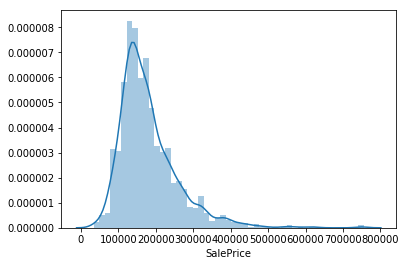

In [4]:
train['SalePrice'].describe()
sns.distplot(train['SalePrice'])
# as we can tell, it is skewed, so we apply log transformation below

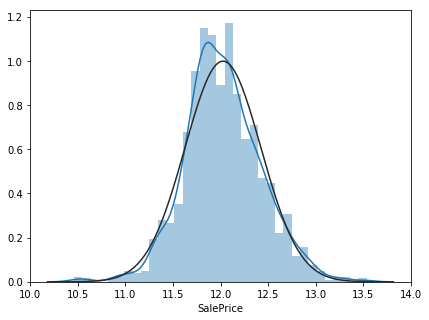

In [5]:
# Apply transformation (take log of Y)
train.SalePrice = np.log1p(train.SalePrice)

# New prediction
y_train = train.SalePrice.values
#y = y_train
#y_train_orig = train.SalePrice

# Now log(Y) is more normally distributed 
# Notice that we are only transforming Y for training data. 
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train['SalePrice'] , fit=norm);
(mu, sigma) = norm.fit(train['SalePrice'])

## 3. Data Cleaning: Missing Value Imputation

In [6]:
# clean the data and compute the % of missingness to confirm
# this make sense, as the test dataset does NOT have sales price 
# salePrice dropping later
# cleaning function from the data_cleaning module
df = data_cleaning.clean(df)
data_cleaning.computeMissingness(df).head()

,Total,Percent
SalePrice,1459,0.500171
Electrical,0,0.000000
ExterCond,0,0.000000
ExterQual,0,0.000000
Exterior1st,0,0.000000


### Data transformation - adjust skewness of numerical variables 

In [7]:
# Make the distinguishment between numerical vs. categorical for easier analysis
categorical_features = df.select_dtypes(include=['object']).columns
print(categorical_features)

numerical_features = df.select_dtypes(exclude = ["object"]).columns
print(numerical_features)

print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
feat_num = df[numerical_features]
feat_cat = df[categorical_features]

Index(['Alley', 'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'BsmtQual', 'CentralAir', 'Condition1', 'Condition2',
       'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd',
       'Fence', 'FireplaceQu', 'Foundation', 'Functional', 'GarageCond',
       'GarageFinish', 'GarageQual', 'GarageType', 'Heating', 'HeatingQC',
       'HouseStyle', 'KitchenQual', 'LandContour', 'LandSlope', 'LotConfig',
       'LotShape', 'MSSubClass', 'MSZoning', 'MasVnrType', 'MiscFeature',
       'Neighborhood', 'PavedDrive', 'PoolQC', 'RoofMatl', 'RoofStyle',
       'SaleCondition', 'SaleType', 'Street', 'Utilities'],
      dtype='object')
Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF',
       'EnclosedPorch', 'Fireplaces', 'FullBath', 'GarageArea', 'GarageCars',
       'GarageYrBlt', 'GrLivArea', 'HalfBath', 'KitchenAbvGr', 'LotArea',
       'LotFrontage', 'LowQua

In [8]:
# Those years are not really numerical, need to remove from feat_num
# Otherwise it intervenes our skewness adjustment that is designed specifically for real numerical features. 
feat_num = feat_num.drop('YearBuilt',axis =1)
feat_num = feat_num.drop('YearRemodAdd',axis =1)
feat_num = feat_num.drop('YrSold',axis =1)
feat_num = feat_num.drop('GarageYrBlt',axis =1)

feat_num.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,...,MoSold,OpenPorchSF,OverallCond,OverallQual,PoolArea,SalePrice,ScreenPorch,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF
0,856,854,0,3,706,0,1,0,150,0,...,2,61,5,7,0,208500.0,0,8,856,0
1,1262,0,0,3,978,0,0,1,284,0,...,5,0,8,6,0,181500.0,0,6,1262,298
2,920,866,0,3,486,0,1,0,434,0,...,9,42,5,7,0,223500.0,0,6,920,0
3,961,756,0,3,216,0,1,0,540,272,...,2,35,5,7,0,140000.0,0,7,756,0
4,1145,1053,0,4,655,0,1,0,490,0,...,12,84,5,8,0,250000.0,0,9,1145,192


In [9]:
from scipy.stats import skew 
# we need to transform those numerical features where skewness is > 0.5
# abs(skewness)>1  highly sknewed 
# 1 > abs(skewness) > 0.5 moderately sknewed
# we are taking the conservative approach and adjusting for moderately skewed 

skewness = feat_num.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))
print("Mean skewnees: {}".format(np.mean(skewness)))

skewness.sort_values(ascending=False)

There are 25 skewed numerical features to Box Cox transform
Mean skewnees: 4.549537328014406


MiscVal          21.939672
PoolArea         17.688664
LotArea          13.109495
LowQualFinSF     12.084539
3SsnPorch        11.372080
KitchenAbvGr      4.300550
BsmtFinSF2        4.144503
EnclosedPorch     4.002344
ScreenPorch       3.945101
BsmtHalfBath      3.929996
MasVnrArea        2.621719
OpenPorchSF       2.529358
WoodDeckSF        1.844792
1stFlrSF          1.257286
LotFrontage       1.103039
GrLivArea         1.068750
BsmtFinSF1        0.980645
BsmtUnfSF         0.919688
2ndFlrSF          0.861556
TotRmsAbvGrd      0.749232
Fireplaces        0.725278
HalfBath          0.696666
TotalBsmtSF       0.671751
BsmtFullBath      0.622415
OverallCond       0.569314
dtype: float64

### boxcox transformation for highly skewed variables 

In [10]:
from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    feat_num[feat] = boxcox1p(feat_num[feat], boxcox_normmax(feat_num[feat] + 1))
    df[feat] = boxcox1p(df[feat], boxcox_normmax(df[feat] + 1))
    
skewness = feat_num.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]

print("There are {} skewed numerical features after Box Cox transform".format(skewness.shape[0]))
print("Mean skewnees: {}".format(np.mean(skewness)))
skewness.sort_values(ascending=False)

There are 16 skewed numerical features after Box Cox transform
Mean skewnees: 3.6754885146513057


PoolArea         15.595057
3SsnPorch         8.862045
LowQualFinSF      8.492615
MiscVal           5.237983
BsmtHalfBath      3.779434
KitchenAbvGr      3.778336
ScreenPorch       3.152631
BsmtFinSF2        2.578329
EnclosedPorch     2.149133
MasVnrArea        0.977618
2ndFlrSF          0.895453
WoodDeckSF        0.785550
HalfBath          0.732625
OpenPorchSF       0.621231
BsmtFullBath      0.616643
Fireplaces        0.553135
dtype: float64

#####  We moved from 25 skewned numerical data to 16 skewed. That's an accomplishment! 

### Dummify 

In [11]:
# dropping SalePrice
df = df.drop("SalePrice", axis = 1)
# one liner code to dummify categorical variables 
df = pd.get_dummies(df)

### Check for multiColinearity

In [12]:
# Correlation with the SalePrice variable
corr = train.corr()['SalePrice']
corr[np.argsort(corr, axis=0)[::-1]].head()

SalePrice      1.000000
OverallQual    0.821405
GrLivArea      0.725211
GarageCars     0.681033
GarageArea     0.656129
Name: SalePrice, dtype: float64

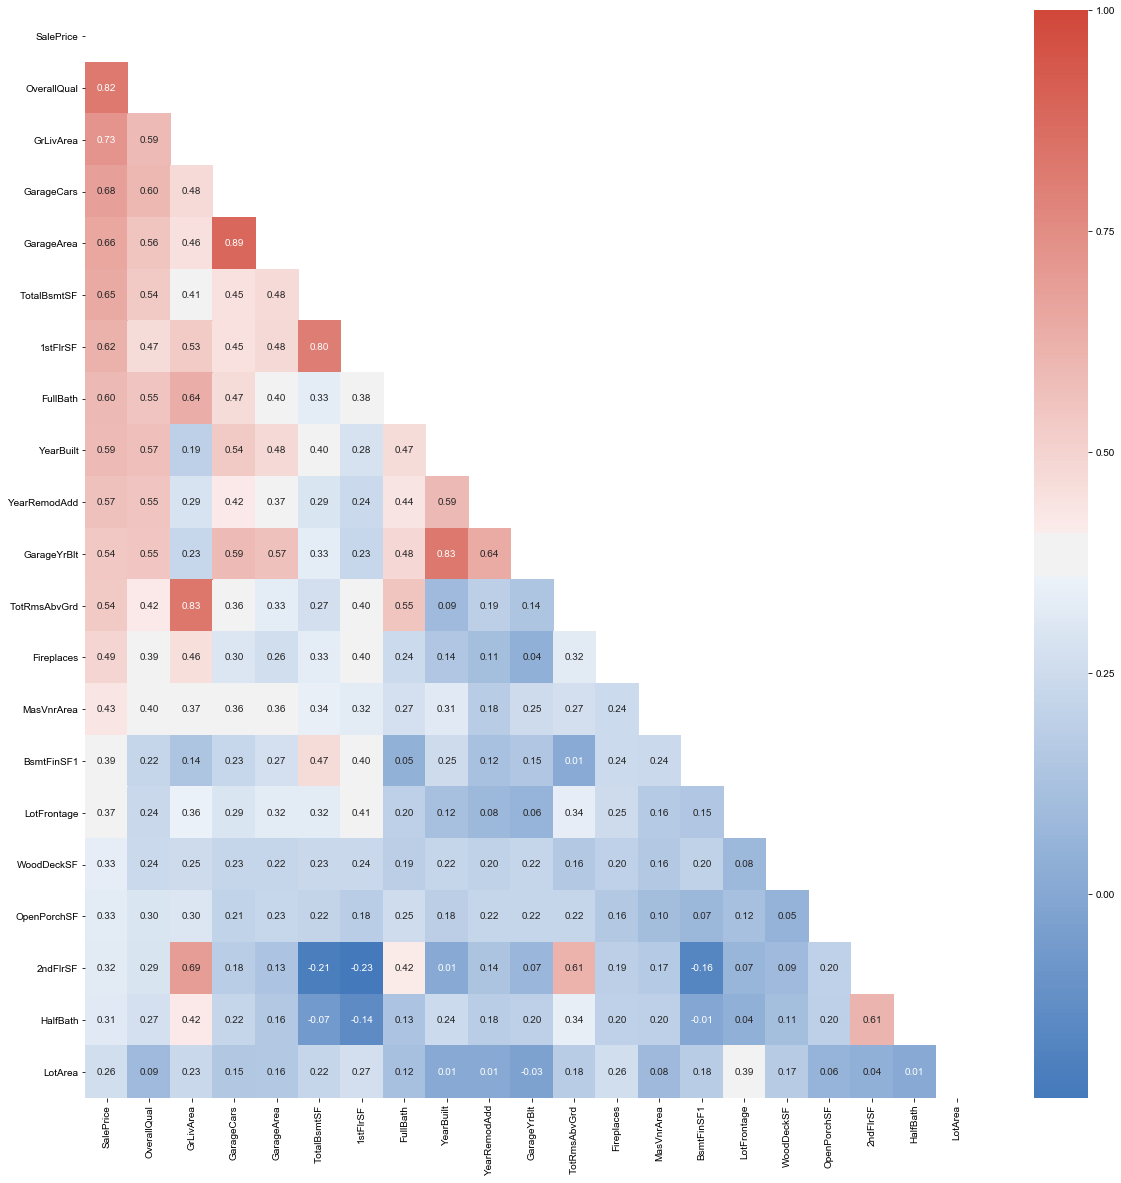

In [13]:
# heatmap for highly correlated variables
corr = train[train.SalePrice>1].corr()
top_corr_cols = corr[abs((corr.SalePrice)>=.25)].SalePrice.sort_values(ascending=False).keys()
top_corr = corr.loc[top_corr_cols, top_corr_cols]
dropSelf = np.zeros_like(top_corr)
dropSelf[np.triu_indices_from(dropSelf)] = True
plt.figure(figsize=(20, 20))
sns.heatmap(top_corr, cmap=sns.diverging_palette(250, 15, as_cmap=True), annot=True, fmt=".2f", mask=dropSelf)
sns.set(font_scale=0.4)
plt.show()
del corr, dropSelf, top_corr

In [14]:
# remove builtyear and renewyear -- check if they're similar, and maybe drop 

In [15]:
correlations = train.corr()
correlations = correlations.iloc[:36, :36] 
cut_off = 0.5
high_corrs = correlations[correlations.abs() > cut_off][correlations.abs() != 1].unstack().dropna().to_dict()
high_corrs = pd.Series(high_corrs, index = high_corrs.keys())
high_corrs = high_corrs.reset_index()
high_corrs = pd.DataFrame(high_corrs)
high_corrs.columns = ['1stAttribute', '2ndAttribute', 'Correlations']
high_corrs['Correlations'] = high_corrs['Correlations'].drop_duplicates(keep = 'first')
high_corrs.dropna().sort_values(by = 'Correlations', ascending = False)

# some high correlated variables: if we do lasso, it will take care of it
# so we're not really doing anything

,1stAttribute,2ndAttribute,Correlations
52,GarageCars,GarageArea,0.887304
31,GrLivArea,TotRmsAbvGrd,0.829498
10,YearBuilt,GarageYrBlt,0.825317
19,TotalBsmtSF,1stFlrSF,0.803830
22,2ndFlrSF,GrLivArea,0.694678
39,BedroomAbvGr,TotRmsAbvGrd,0.680390
16,BsmtFinSF1,BsmtFullBath,0.658507
14,YearRemodAdd,GarageYrBlt,0.641604
29,GrLivArea,FullBath,0.638378
25,2ndFlrSF,TotRmsAbvGrd,0.614034


### Data engineering  - from above, we definitely see some high correlation between variables that deal with "area".  Here we are combining some area-related variable.

In [16]:
#  Adding total sqfootage feature 
df['TotalSF']=df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

#  Adding total bathrooms feature
df['Total_Bathrooms'] = (df['FullBath'] + (0.5 * df['HalfBath']) +
                               df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath']))

#  Adding total porch sqfootage feature
df['Total_porch_sf'] = (df['OpenPorchSF'] + df['3SsnPorch'] +
                              df['EnclosedPorch'] + df['ScreenPorch'] +
                              df['WoodDeckSF'])

########### tried dropping used variables, but doesn't nessarily improve the scores
# dropping old variables could predict worse because they imply different things, contextually
# e.g. for homebuyers, totalsf could be more important than TotalBsmtSF, etc. 
# df = df.drop(['TotalBsmtSF','1stFlrSF','2ndFlrSF','FullBath',
#         'HalfBath','BsmtFullBath','BsmtHalfBath','OpenPorchSF',
#         '3SsnPorch','EnclosedPorch','ScreenPorch','WoodDeckSF'],axis=1)

In [17]:
for col in ['TotalSF','Total_Bathrooms','Total_porch_sf']:
    #for feat in skewed_features:
    print("Skewness before box cox: ",col,skew(df[col]))
    
# check for skewness for the new combined variables & do boxcox if heavily skewed
for col in ['TotalSF','Total_Bathrooms','Total_porch_sf']:
    #for feat in skewed_features:
    df[col] = boxcox1p(df[col], boxcox_normmax(df[col] + 1))
    print("Skewness after box cox: ",col,skew(df[col]))

Skewness before box cox:  TotalSF 0.9601595214856753
Skewness before box cox:  Total_Bathrooms 0.4961104873762132
Skewness before box cox:  Total_porch_sf 0.6437506876448505
Skewness after box cox:  TotalSF 0.20283840649332527
Skewness after box cox:  Total_Bathrooms 0.1192328188050751
Skewness after box cox:  Total_porch_sf 0.11095318002076615


## splitting back to X, Y, test, train

In [18]:
# Just make sure one more time that we are capturing the right data for train & test 
print(df.shape)
X_train= df.iloc[:len(y_train), :]
X_test = df.iloc[len(y_train):, :]

print(X_train.shape,y_train.shape,X_test.shape)

(2917, 320)
(1458, 320) (1458,) (1459, 320)


### Modeling 

In [19]:
# Import all the necessary packages for modeling 
from datetime import datetime
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error , make_scorer
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

/Users/chloeymoon/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


#### Functinalize things before starting:

In [20]:
# Write the CV and RMSE function beforehead 
# 10 fold 
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

# model scoring and validation function
# cross validation score
def cv_rmse(model, X=X_train):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train,scoring="neg_mean_squared_error",cv=kfolds))
    return (rmse)

# rmsle scoring function
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

# Park the range of values that the model considers each time in runs 
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]

#### Build up models 

In [ ]:
# grid search for lightgbm

from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
param_grid = [{'alpha':[1.0,0.9,1.1]}]
lgbm_grid = GridSearchCV(LGBMRegressor(), param_grid, cv=10)
#housing_grid
lgbm_grid.fit(X_train, y_train)
#print(lgbm_grid.grid_scores_)
print(lgbm_grid.best_estimator_)

In [21]:
# Pipeline allows us to cross-validate models together
# while setting different parameters.Otherwise, we have to take repetitive steps to CV models (too manual)
# http://www.marcosantoni.com/2016/06/19/a-simple-machine-learning-pipeline.html
# Did not use Grid Search as that is extremely time consuming, so we opted for pipeline instead (i.e.set up hyperparameters using pipeline)

#RobustScaler removes the median and scales the data according to the quantile range

# Ridge
ridge = make_pipeline(RobustScaler(), RidgeCV(cv=kfolds))
# alphas=alphas_alt

# LASSO 
lasso = make_pipeline(RobustScaler(),
                      LassoCV(max_iter=1e7, random_state=42, cv=kfolds))
# alphas=alphas2

# Elastic Net 
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, 
                          cv=kfolds, l1_ratio=e_l1ratio))
# alphas=e_alphas,


######## params selected after grid search
# lightgbm
lightgbm = LGBMRegressor(objective='regression', 
                           num_leaves=4, #was 3
                           learning_rate=0.01, 
                           n_estimators=8000,
                           max_bin=200, 
                           bagging_fraction=0.75,
                           bagging_freq=5, 
                           bagging_seed=7,
                           feature_fraction=0.2, # 'was 0.2'
                           feature_fraction_seed=7,
                           verbose=-1
                                       )

# from gridsearchcv
# LGBMRegressor(alpha=1.0, boosting_type='gbdt', class_weight=None,
#        colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
#        max_depth=-1, min_child_samples=20, min_child_weight=0.001,
#        min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
#        objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
#        silent=True, subsample=1.0, subsample_for_bin=200000,
#        subsample_freq=0)

# xgboost 
xgboost = XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:squarederror', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)

# Gradient Boosting
gbst = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =111)


# Random Forest, using randomized grid search

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 100)]
max_features = ['sqrt']
max_depth = [int(x) for x in np.linspace(5, 20, 16)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = kfolds, verbose=2, random_state=42, n_jobs = -1)


In [22]:
# This is the list of models we are running 
models = {
          'ridge': ridge,
          'Lasso': lasso, 
          'ElasticNet': elasticnet,
          'lightgbm': lightgbm,
          'xgboost': xgboost,
          'gbst':gbst,
          'rf':rf}
predictions = {}
scores = {}
rmse = {}
inv_rmse = {}
model_score={}

In [23]:
# meta regressors for stackings

mega_elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, 
                          cv=kfolds, l1_ratio=e_l1ratio))


#### Now, train models 

In [24]:
# write a function to calculate RMSE of models 
for name, model in models.items():
    #y = y_train
    model.fit(X_train, y_train)
    
    predictions[name] = model.predict(X_train) # because y_train is logged #np.expm1(
    score = cv_rmse(model, X=X_train)
    scores[name] = (score.mean(), score.std())
    # Returns the coefficient of determination R^2 of the prediction.
    model_score[name] = model.score(X_train,y_train)

/Users/chloeymoon/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [25]:
scores

{'ridge': (0.10804600327471026, 0.015823729989958023),
 'Lasso': (0.11160976047242206, 0.016445584340702632),
 'ElasticNet': (0.11161336367955972, 0.016450298699031033),
 'lightgbm': (0.1128897931527189, 0.01607701840173431),
 'xgboost': (0.11171890335621595, 0.01532107742911438),
 'gbst': (0.11436772292256843, 0.015563572034318142),
 'rf': (0.1415193953388028, 0.013250262613149393)}

In [26]:
model_score

{'ridge': 0.945603579252057,
 'Lasso': 0.9294791440763561,
 'ElasticNet': 0.9294791440763561,
 'lightgbm': 0.9741150819030323,
 'xgboost': 0.9846423515618788,
 'gbst': 0.984289887827191,
 'rf': 0.976240130554782}

In [27]:
rmse = {}
inv_rmse = {}
for name, pred in predictions.items():
    rmse[name] = np.sqrt(mean_squared_error(y_train, pred)) #numpy.rmsle(y_train,pred)
    inv_rmse[name] = 1- np.sqrt(mean_squared_error(y_train, pred))
rmse

{'ridge': 0.0931932080393325,
 'Lasso': 0.10611038423684298,
 'ElasticNet': 0.10611038423684298,
 'lightgbm': 0.06428690197652415,
 'xgboost': 0.04951781359146858,
 'gbst': 0.05008281633038526,
 'rf': 0.06159154874843088}

In [28]:
inv_rmse

{'ridge': 0.9068067919606675,
 'Lasso': 0.8938896157631571,
 'ElasticNet': 0.8938896157631571,
 'lightgbm': 0.9357130980234758,
 'xgboost': 0.9504821864085314,
 'gbst': 0.9499171836696148,
 'rf': 0.9384084512515691}

#### Now that we have random forest, it's time to use that to see feature importance 
#### Can add this part to EDA part during presentation 

In [ ]:
from tabulate import tabulate
headers = ["name", "score"]
values = sorted(zip(X.columns, model.feature_importances_), key=lambda x: x[1] * -1)
print(tabulate(values, headers, tablefmt="plain"))

#### Fit the training data X, y

In [24]:
print('----START Fit----',datetime.now())

print('Elasticnet')
elastic_model = elasticnet.fit(X_train, y_train)

print('Lasso')
lasso_model = lasso.fit(X_train, y_train)

print('Ridge')
ridge_model = ridge.fit(X_train, y_train)

print('lightgbm')
lgb_model = lightgbm.fit(X_train, y_train)

print('xgboost')
xgboost_model = xgboost.fit(X_train, y_train)

print('gbst')
gbst_model = gbst.fit(X_train, y_train)

print('rf')
rf_model = rf.fit(X_train, y_train)

----START Fit---- 2019-07-30 04:49:46.573867
Elasticnet
Lasso
Ridge
lightgbm
xgboost
gbst
rf


### Stack the models!

In [25]:
avg = 1/7
avg

0.14285714285714285

In [26]:
X_train.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,...,SaleType_Oth,SaleType_WD,Street_Grvl,Street_Pave,Utilities_AllPub,Utilities_NoSeWa,Utilities_None,TotalSF,Total_Bathrooms,Total_porch_sf
0,5.939033,1025.651978,0.0,3,144.117862,0.0,0.99344,0.000000,29.991052,0.000000,...,0,1,0,1,1,0,0,115.452964,2.281670,6.922379
1,6.234989,0.000000,0.0,3,181.719186,0.0,0.00000,0.710895,44.135410,0.000000,...,0,1,0,1,1,0,0,68.503726,1.678542,21.268792
2,5.994335,1040.521059,0.0,3,110.441033,0.0,0.99344,0.000000,56.896528,0.000000,...,0,1,0,1,1,0,0,117.423657,2.281670,5.949505
3,6.027703,904.477422,0.0,3,61.795315,0.0,0.99344,0.000000,64.808848,16.020712,...,0,1,0,1,1,0,0,107.577685,1.472103,11.876742
4,6.161220,1273.024862,0.0,4,136.624601,0.0,0.99344,0.000000,61.166371,0.000000,...,0,1,0,1,1,0,0,131.898821,2.281670,21.358159


In [ ]:
# with everything
stack_models = StackingCVRegressor(regressors=(ridge, lasso, elasticnet,lightgbm, xgboost,gbst,rf), #elasticnet,
                                    meta_regressor=mega_elasticnet,
                                    use_features_in_secondary=True)
stack_models.fit(X_train.values, y_train)
stacked = stack_models.predict(X_test.values)

In [ ]:
rmsle(y_train, stack_models.predict(X_train.values))

In [ ]:
# without elasticnet
stack_models_no_EN = StackingCVRegressor(regressors=(ridge, lasso, lightgbm, xgboost,gbst,rf), #elasticnet,
                                    meta_regressor=mega_elasticnet,
                                    use_features_in_secondary=True)
stack_models_no_EN.fit(X_train.values, y_train)
stacked = stack_models_no_EN.predict(X_test.values)

In [ ]:
rmsle(y_train, stack_models_no_EN.predict(X_train.values))

In [ ]:
# weights as proportion 
avg = 1/7
def stacked_models_avg(X):
    return ((avg  * elastic_model.predict(X)) + \
            (avg * lasso_model.predict(X)) + \
            (avg * ridge_model.predict(X)) + \
            (avg * lgb_model.predict(X)) + \
            (avg * xgboost_model.predict(X)) + \
            (avg * gbst_model.predict(X)) + \
            (avg * rf_model.predict(X)))

print('RMSLE score on train data:')
print(rmsle(y_train, stacked_models_avg(X_train)))

In [ ]:
avg = 1/6
def stacked_models_avg_noEL(X):
    return (#(avg  * elastic_model.predict(X)) + \
            (avg * lasso_model.predict(X)) + \
            (avg * ridge_model.predict(X)) + \
            (avg * lgb_model.predict(X)) + \
            (avg * xgboost_model.predict(X)) + \
            (avg * gbst_model.predict(X)) + \
            (avg * rf_model.predict(X)))

print('RMSLE score on train data:')
print(rmsle(y_train, stacked_models_avg_noEL(X_train)))

In [ ]:
# weights as proportion 
def stacked_models_weight1(X):
    s = sum(inv_rmse.values())
    return ((inv_rmse['ElasticNet']/s  * elastic_model.predict(X)) + \
            (inv_rmse['Lasso']/s * lasso_model.predict(X)) + \
            (inv_rmse['ridge']/s * ridge_model.predict(X)) + \
            (inv_rmse['lightgbm']/s * lgb_model.predict(X)) + \
            (inv_rmse['xgboost']/s * xgboost_model.predict(X)) + \
            (inv_rmse['gbst']/s * gbst_model.predict(X)) + \
            (inv_rmse['rf']/s * rf_model.predict(X)))

print('RMSLE score on train data:')
print(rmsle(y_train, stacked_models_weight1(X_train)))

In [ ]:
# weights as proportion 
def stacked_models_weight1_noEL(X):
    s = sum(inv_rmse.values())-inv_rmse['ElasticNet']
    return (#(inv_rmse['ElasticNet']/s  * elastic_model.predict(X)) + \
            (inv_rmse['Lasso']/s * lasso_model.predict(X)) + \
            (inv_rmse['ridge']/s * ridge_model.predict(X)) + \
            (inv_rmse['lightgbm']/s * lgb_model.predict(X)) + \
            (inv_rmse['xgboost']/s * xgboost_model.predict(X)) + \
            (inv_rmse['gbst']/s * gbst_model.predict(X)) + \
            (inv_rmse['rf']/s * rf_model.predict(X)))

print('RMSLE score on train data:')
print(rmsle(y_train, stacked_models_weight1_noEL(X_train)))

In [ ]:
submission = pd.read_csv("./sample_submission.csv")
submission.iloc[:,1] = (np.expm1(stacked_models_avg(X_test)))
submission.to_csv("submission_07.28.19_chloe_avg_Dropped.csv", index=False)

In [ ]:
submission = pd.read_csv("./sample_submission.csv")
submission.iloc[:,1] = (np.expm1(xgboost_model.predict(X_test)))
submission.to_csv("submission_07.28.19_chloe_xgboost.csv", index=False)

In [ ]:
submission = pd.read_csv("./sample_submission.csv")
submission.iloc[:,1] = (np.expm1(stacked))
submission.to_csv("submission_07.28.19_chloe_stackedregressor_elasticnet.csv", index=False)

In [ ]:
submission = pd.read_csv("./sample_submission.csv")
submission.iloc[:,1] = (np.expm1(stacked_models_weight1_noEL(X_test)))
submission.to_csv("submission_07.28.19_chloe_weight_noEL.csv", index=False)